In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
files = "./data"

In [91]:
def preprocess_data(files):
    dfs = []
    directing_df = pd.DataFrame()
    writing_df = pd.DataFrame()
    for file in os.listdir(files):
        fn_no_ext = file.split(".")[0]
        if ".json" in file:
            globals()[fn_no_ext+"_df"] = pd.read_json(os.path.join(files, file))
            print("Created ", fn_no_ext+"_df", " dataframe.")
        elif ".csv" in file:
            if "validation" in file:
                validation_df = pd.read_csv(os.path.join(files, file), index_col=0, na_values=['\\N'])
                continue
            elif "test" in file:
                test_df = pd.read_csv(os.path.join(files, file), index_col=0, na_values=['\\N'])
                continue
            df = pd.read_csv(os.path.join(files, file), index_col=0, na_values=['\\N'])
            print("Appending: ", df.shape[0], " rows...")
            dfs.append(df)
            train_df = pd.concat(dfs, ignore_index=True)
        else: 
            pass
        
    directing_df = globals()['directing_df']
    directing_df.replace('\\N', pd.NA, inplace=True)
    writing_df = globals()['writing_df']    
    writing_df.replace('\\N', pd.NA, inplace=True)


    return train_df, validation_df, test_df, directing_df, writing_df
    


In [92]:
train, validation, test, directing_df, writing_df = preprocess_data(files)
print("Train shape: ", train.shape)
print("Validation shape: ", validation.shape)
print("Test shape: ", test.shape)

Created  directing_df  dataframe.
Appending:  963  rows...
Appending:  993  rows...
Appending:  951  rows...
Appending:  1049  rows...
Appending:  974  rows...
Appending:  1001  rows...
Appending:  1035  rows...
Appending:  993  rows...
Created  writing_df  dataframe.
Train shape:  (7959, 8)
Validation shape:  (955, 7)
Test shape:  (1086, 7)


## Data cleaning

In [93]:
# TODO remove writers without movies
writing_df = writing_df.dropna()

# TODO Meaning of end and start Date, maybe we can only keep one col


## EDA

There are N director for each movie

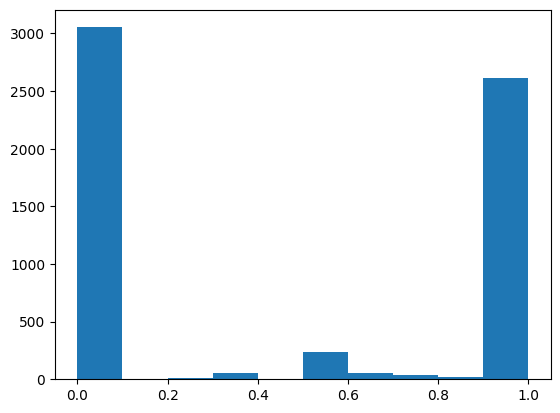

In [94]:
directing_score = directing_df.merge(train, how="inner", left_on="movie", right_on="tconst")
directing_score = directing_score.groupby("director").agg([ "sum", "count"])["label"]
directing_score["score"] = directing_score["sum"]/directing_score["count"]
directing_df = directing_df.merge(directing_score, how="left", left_on="director", right_on="director")
directing_df = directing_df.fillna(0.5)
plt.hist(directing_score["score"])
plt.show()


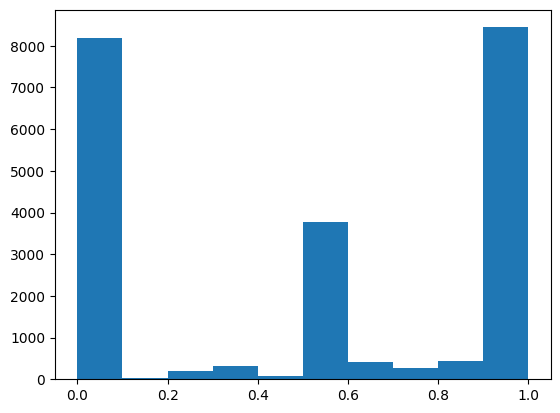

In [95]:
writing_score = writing_df.merge(train, how="inner", left_on="movie", right_on="tconst")
writing_score = writing_score.groupby("writer").agg([ "sum", "count"])["label"]
writing_score["score"] = writing_score["sum"]/writing_score["count"]
writing_df = writing_df.merge(writing_score, how="left", left_on="writer", right_on="writer")
writing_df = writing_df.fillna(0.5)
plt.hist(writing_df["score"])
plt.show()

In [178]:
def get_scores_train(df):
    df = df.merge(directing_df, how="left", left_on="tconst", right_on="movie", suffixes=("_directors", "_writers"))
    df = df.groupby(["tconst","numVotes", "runtimeMinutes", "label"])[["score"]].agg(["mean", "count"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df[["score_mean", "score_count"]]
    df = df.rename(columns={"score_mean":"avg_director_score", "score_count":"n_directors"})
    df = df.reset_index()
    df = df.merge(writing_df, how="left", left_on="tconst", right_on="movie", suffixes=("_directors", "_writers"))
    df = df.groupby(["tconst", "numVotes", "runtimeMinutes", "avg_director_score", "n_directors", "label"])[["score"]].agg(["mean", "count"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df.reset_index()
    df = df.rename(columns={"score_mean":"avg_writer_score", "score_count":"n_writers"})
    return df

In [200]:
def get_scores_val_test(df):
    # Same as the previous method but removing the label column from it
    df = df.merge(directing_df, how="left", left_on="tconst", right_on="movie", suffixes=("_directors", "_writers"))
    df = df.groupby(["tconst","numVotes", "runtimeMinutes"])[["score"]].agg(["mean", "count"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df[["score_mean", "score_count"]]
    df = df.rename(columns={"score_mean":"avg_director_score", "score_count":"n_directors"})
    df = df.reset_index()
    df = df.merge(writing_df, how="left", left_on="tconst", right_on="movie", suffixes=("_directors", "_writers"))
    df = df.groupby(["tconst", "numVotes", "runtimeMinutes", "avg_director_score", "n_directors"])[["score"]].agg(["mean", "count"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df.reset_index()
    df = df.rename(columns={"score_mean":"avg_writer_score", "score_count":"n_writers"})
    return df

In [180]:
train = get_scores_train(train)


## Simple Machine Learning Pipeline

In [144]:
# TODO add writters and directors as categorical features to the data, for instance movie tt0401711 will have 29 ones and 15247 zeros

In [145]:
# TODO do the same with directors

In [181]:
train.head()

,tconst,numVotes,runtimeMinutes,avg_director_score,n_directors,label,avg_writer_score,n_writers
0,tt0009369,1119.0,93.0,0.0,2,False,0.000000,2
1,tt0010600,1898.0,66.0,1.0,1,True,0.916667,4
2,tt0011439,2439.0,79.0,1.0,1,True,1.000000,3
3,tt0011607,1264.0,94.0,1.0,1,True,1.000000,2
4,tt0011841,5376.0,145.0,1.0,1,True,1.000000,5


In [192]:
feature_cols = ["runtimeMinutes", "numVotes", "avg_director_score",	"n_directors", "avg_writer_score","n_writers"]
X, y = train[feature_cols], train["label"]

In [193]:
train

,tconst,numVotes,runtimeMinutes,avg_director_score,n_directors,label,avg_writer_score,n_writers
0,tt0009369,1119.0,93.0,0.0,2,False,0.000000,2
1,tt0010600,1898.0,66.0,1.0,1,True,0.916667,4
2,tt0011439,2439.0,79.0,1.0,1,True,1.000000,3
3,tt0011607,1264.0,94.0,1.0,1,True,1.000000,2
4,tt0011841,5376.0,145.0,1.0,1,True,1.000000,5
...,...,...,...,...,...,...,...,...
7152,tt9840958,3769.0,92.0,0.0,1,False,0.000000,2
7153,tt9845110,2451.0,99.0,1.0,1,True,1.000000,3
7154,tt9850344,1325.0,98.0,0.0,1,False,0.000000,3
7155,tt9850386,4144.0,111.0,1.0,1,True,1.000000,1


In [194]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [195]:
clf = RandomForestClassifier(max_depth=2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [50, 100, 200, 300]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best parameters:", best_params)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(X_test)

# Measure accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Perform K-fold cross-validation and print the mean accuracy
cv_accuracy = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", cv_accuracy.mean())

Best parameters: {'max_depth': 8, 'n_estimators': 100}
Accuracy: 0.985470801899972
Cross-validated Accuracy: 0.9846271047388366


### Overfitting a bit hehe 

## Prepare CSV files for kaggle

Asuming that the format will be index + prediction

In [198]:
validation = get_scores_val_test(validation)
test = get_scores_val_test(test)

In [199]:
validation["label"] = best_estimator.predict(validation[feature_cols])
test["label"] = best_estimator.predict(test[feature_cols])

validation["label"].to_csv("val_result.csv")
test["label"].to_csv("test_result.csv")